In [1279]:
from bs4 import BeautifulSoup
import requests
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In this section, the datasets used are from https://crowding.data.tfl.gov.uk/. The station entry / exit counts in these datasets represent the entry / exit or boarding / alighting count at each station on a typical weekday (Monday-Thursday), Friday, Saturday or Sunday, and annualised to an annual entry / exit total. Datasets from 2017 to 2023 are used.

## Preprocessing Data
#### Cleaning, manipulating, and transforming data to make it suitable for analysis

In [1280]:
def get_clean(file):
    """ Reads an Excel file, cleans the data, and returns a DataFrame.
    Takes an object of string type: The name of the Excel file to read.
    Returns a clean DataFrame """
    # Construct a relative file path to the data file.
    path = os.path.join('..', '2024-project-sustainability-pathfinders', 'data', file)
    df = pd.read_excel(path)
    df = df[4:]
    df = df.reset_index(drop=True)
    df.columns = df.iloc[0].fillna('') + '_' + df.iloc[1].fillna('') 
    df = df[2:].reset_index(drop=True)
    return df


In [1281]:
df_2017 = get_clean('AnnualisedEntryExit_2017.xlsx')
df_2018 = get_clean('AnnualisedEntryExit_2018.xlsx')
df_2019 = get_clean('AnnualisedEntryExit_2019.xlsx')
df_2020 = get_clean('AC2020_AnnualisedEntryExit.xlsx')
df_2021 = get_clean('AC2021_AnnualisedEntryExit.xlsx')
df_2022 = get_clean('AC2022_AnnualisedEntryExit.xlsx')
df_2023 = get_clean('AC2023_AnnualisedEntryExit.xlsx')

In [1282]:
def prepare_df(df): 
    """ Takes a DataFrame and returns a DataFrame prepared for merging."""
    # Strip any leading/trailing whitespace from column names
    df.columns = df.columns.str.strip()
    # Rename the last column to 'Annualised_en/ex'
    df.rename(columns={df.columns[-1]: 'Annualised_en/ex'}, inplace=True)
    df = df[['_Station', 'Annualised_en/ex']]
    return df

In [1283]:
p_df_2017 = prepare_df(df_2017)
df_2018 = prepare_df(df_2018)
df_2019 = prepare_df(df_2019)
df_2020 = prepare_df(df_2020)
df_2021 = prepare_df(df_2021)
df_2022 = prepare_df(df_2022)
df_2023 = prepare_df(df_2023)

## Merging DataFrames 

In [1284]:
dfs = [p_df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]

# Iterate over each DataFrame in the list `dfs` and removes duplicate rows based on the '_Station' column.
for i, df in enumerate(dfs):
    dfs[i] = df.drop_duplicates(subset=['_Station'])

In [1285]:
# Merge the DataFrames in the list `dfs` on the '_Station' column.
merged_df = dfs[0]
for i, df in enumerate(dfs[1:], start=2018):
    merged_df = pd.merge(
        merged_df,
        df,
        on=[ '_Station'],
        how='inner',
        suffixes=(f'_{i-1}', f'_{i}')
    )

# Rename the last column to apply the correct suffix
merged_df.columns.values[-1] = 'Annualised_en/ex_2023'

merged_df.head()

,_Station,Annualised_en/ex_2017,Annualised_en/ex_2018,Annualised_en/ex_2019,Annualised_en/ex_2020,Annualised_en/ex_2021,Annualised_en/ex_2022,Annualised_en/ex_2023
0,Acton Town,5731527.111999,5794684.874932,6186555.364307,3568527.645583,2902696.681446,4931971.567425,4823835
1,Aldgate,8459233.624591,9218140.360197,9956599.948513,2775844.467443,3525128.321636,6902494.473203,6897314
2,Aldgate East,13262408.265095,13707738.230351,14148654.22259,3144899.05739,5611129.827751,10229487.644282,10947896
3,Alperton,2896391.378075,2796159.417435,2858439.053271,2064990.286688,1345253.101586,2302972.999045,2598605
4,Amersham,2215501.947089,2130206.990472,2350099.189106,863360.657696,946577.046456,1657141.466305,1729521


In [1286]:
# Drop duplicates in the 2017 dataframe
df_2017 = df_2017.drop_duplicates(subset=['_Station'])

# Perform the merge to add the _Mode column for Network Analysis
merged_df = pd.merge(merged_df, df_2017[['_Mode', '_Station']], on='_Station', how='left')
merged_df.head()

,_Station,Annualised_en/ex_2017,Annualised_en/ex_2018,Annualised_en/ex_2019,Annualised_en/ex_2020,Annualised_en/ex_2021,Annualised_en/ex_2022,Annualised_en/ex_2023,_Mode
0,Acton Town,5731527.111999,5794684.874932,6186555.364307,3568527.645583,2902696.681446,4931971.567425,4823835,LU
1,Aldgate,8459233.624591,9218140.360197,9956599.948513,2775844.467443,3525128.321636,6902494.473203,6897314,LU
2,Aldgate East,13262408.265095,13707738.230351,14148654.22259,3144899.05739,5611129.827751,10229487.644282,10947896,LU
3,Alperton,2896391.378075,2796159.417435,2858439.053271,2064990.286688,1345253.101586,2302972.999045,2598605,LU
4,Amersham,2215501.947089,2130206.990472,2350099.189106,863360.657696,946577.046456,1657141.466305,1729521,LU


## Exploratory Data Analysis

In this section, the datasets used are from https://crowding.data.tfl.gov.uk/. The station entry / exit counts in these datasets represent the entry / exit or boarding / alighting count at each station on a typical weekday (Monday-Thursday), Friday, Saturday or Sunday, and annualised to an annual entry / exit total. Datasets from 2017 to 2021 are used. The following datasets record the passenger counts during six time periods per day. Counts on weekends and weekdays are also recorded seperately.

The period categories are specified as follows:

 - Early - 5:00 to 7:00
 - AM Peak - 7:00 to 10:00
 - Inter Peak - 10:00 to 16:00
 - PM Peak - 16:00 to 19:00
 - Evening - 19:00 to 22:00
 - Late - 22:00 to 05:00

In [1287]:
def get_ByQhr(file):
    """ Reads an Excel file, cleans the data, and returns a DataFrame."""
    # Construct a relative file path to the data file.
    path = os.path.join('..', '2024-project-sustainability-pathfinders', 'data', file)
    df = pd.read_excel(path, sheet_name='ByQhr', header=6)
    df = df.reset_index(drop=True)
    df = df.iloc[:, :15]
    df.columns = df.columns.str.strip()
    df['day'] = df['day'].replace('MTT', 'MTF')
    return df

In [1288]:
ByQhr_2017 = get_ByQhr('ByQhrEntryExit_2017.xlsx')
ByQhr_2018 = get_ByQhr('ByQhrEntryExit_2018.xlsx')
ByQhr_2019 = get_ByQhr('ByQhrEntryExit_2019.xlsx')
ByQhr_2020 = get_ByQhr('AC2020_ByQhrEntryExit.xlsx')
ByQhr_2021 = get_ByQhr('AC2021_ByQhrEntryExit.xlsx')

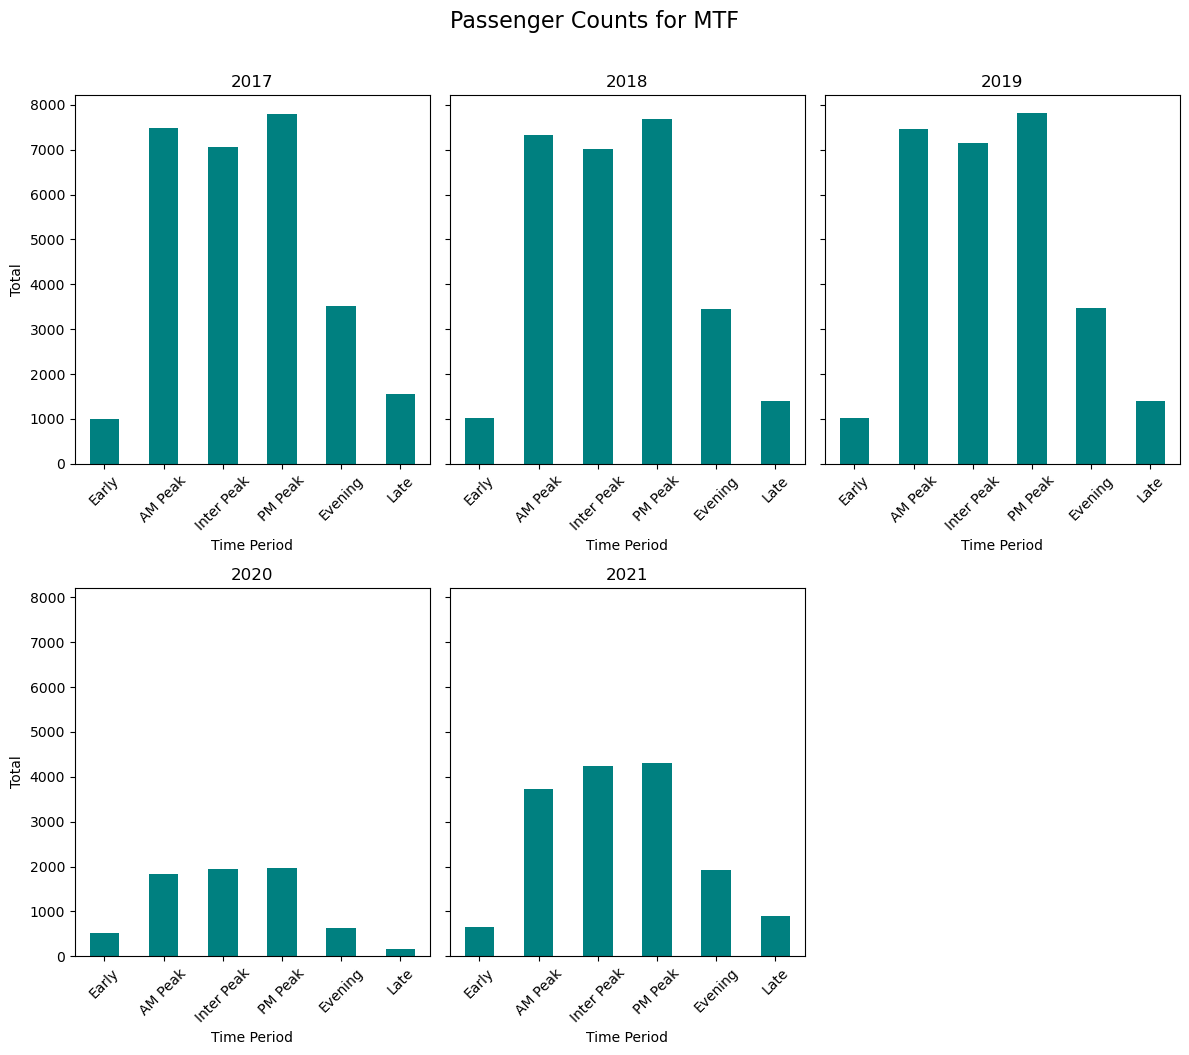

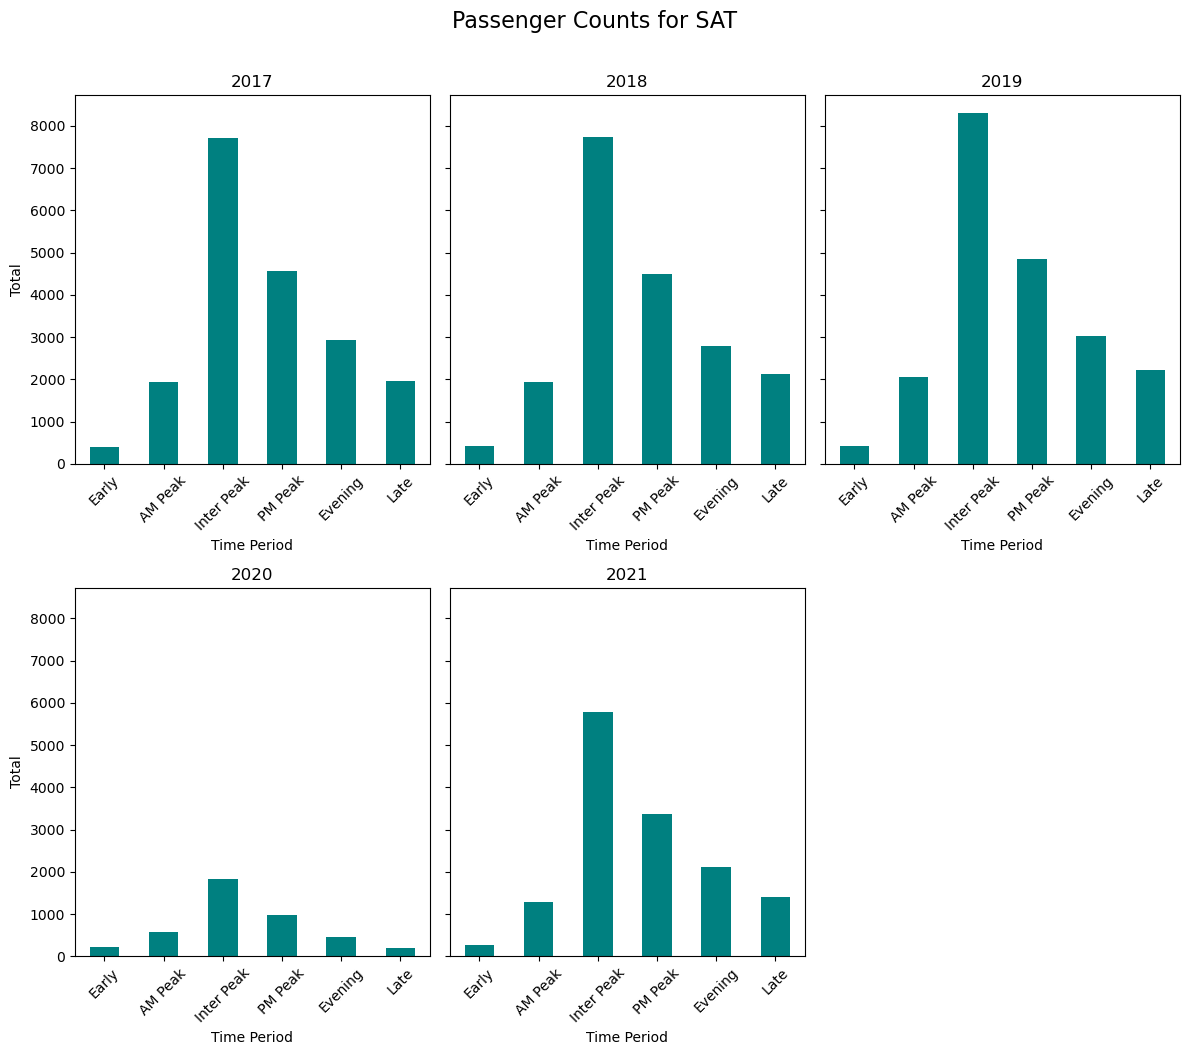

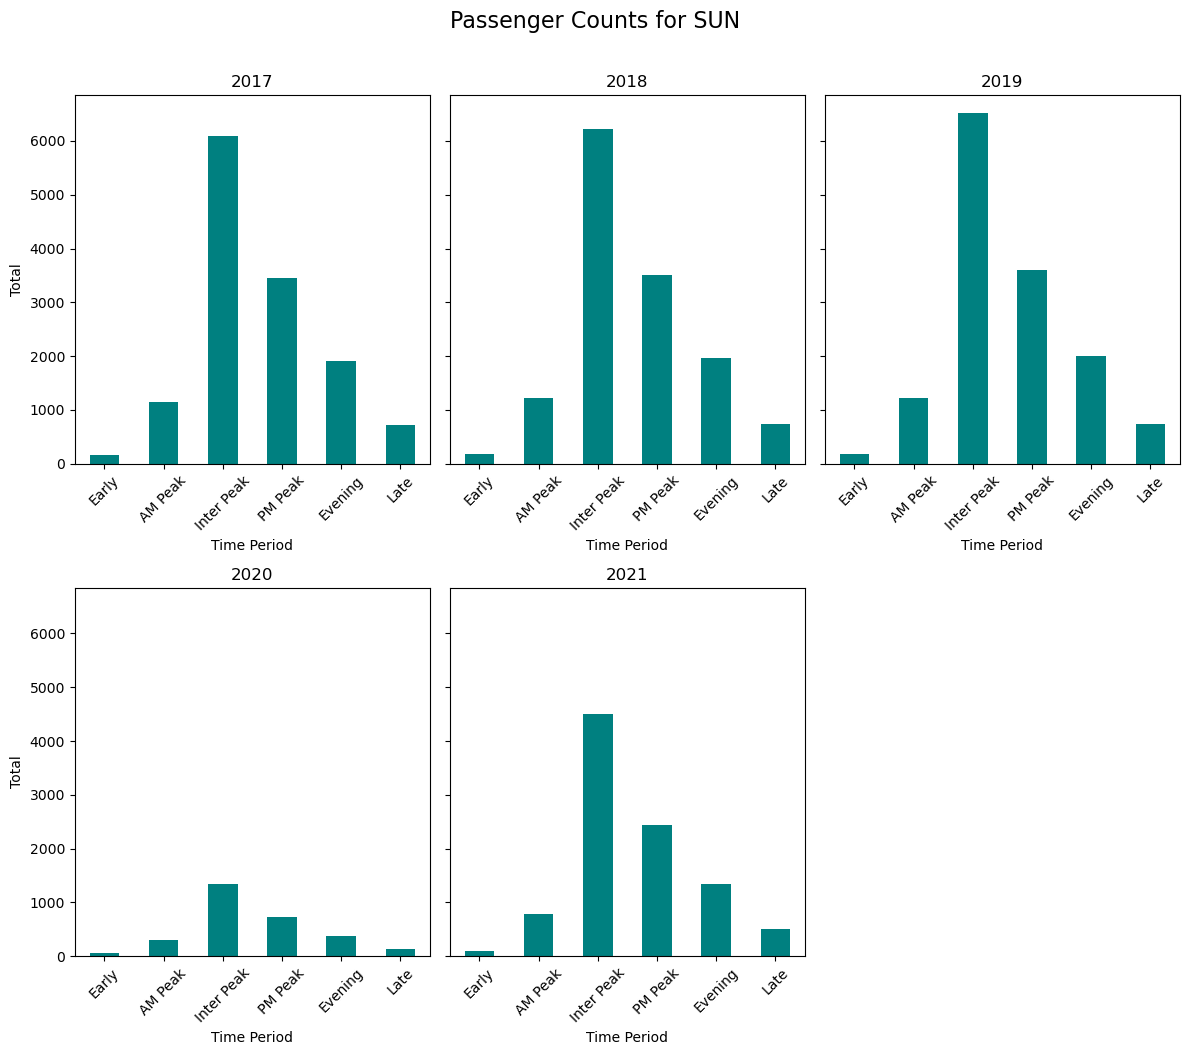

In [1289]:
# Define the categories for 'Day'
day_categories = ByQhr_2017['day'].unique()

# Define the time periods
time_periods = ['Early', 'AM Peak', 'Inter Peak', 'PM Peak', 'Evening', 'Late']

# Create subplots for each year and each category of 'Day'
for day in day_categories:
    fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharey=True)  # 2 rows, 3 columns
    axes = axes.flatten()  # Flatten to 1D array for easier iteration

    for j, year in enumerate([2017, 2018, 2019, 2020, 2021]):
        df = globals()[f'ByQhr_{year}']
        df_day = df[df['day'] == day]
        df_grouped = df_day.groupby('Station')[time_periods].sum()

        df_grouped.mean().plot(kind='bar', ax=axes[j], color='teal')
        axes[j].set_title(f'{year}')
        axes[j].set_xlabel('Time Period')
        axes[j].set_ylabel('Total')
        axes[j].set_xticklabels(time_periods, rotation=45)

    # Hide the unused subplot (6th position if only 5 years)
    if len([2017, 2018, 2019, 2020, 2021]) < 6:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.suptitle(f'Passenger Counts for {day}', y=1.05, fontsize=16)

On weekdays, passenger counts peak during the PM peak period (16:00-19:00), which aligns with typical post-work travel patterns. In contrast, weekends experience the highest passenger volumes during the Inter Peak period (10:00-16:00), as individuals tend to travel for leisure purposes between the previously mentioned hours. The Covid-19 pandemic, not unexpectedly, resulted in a decline in passenger numbers across all time periods and days of the week during 2020 and 2021.

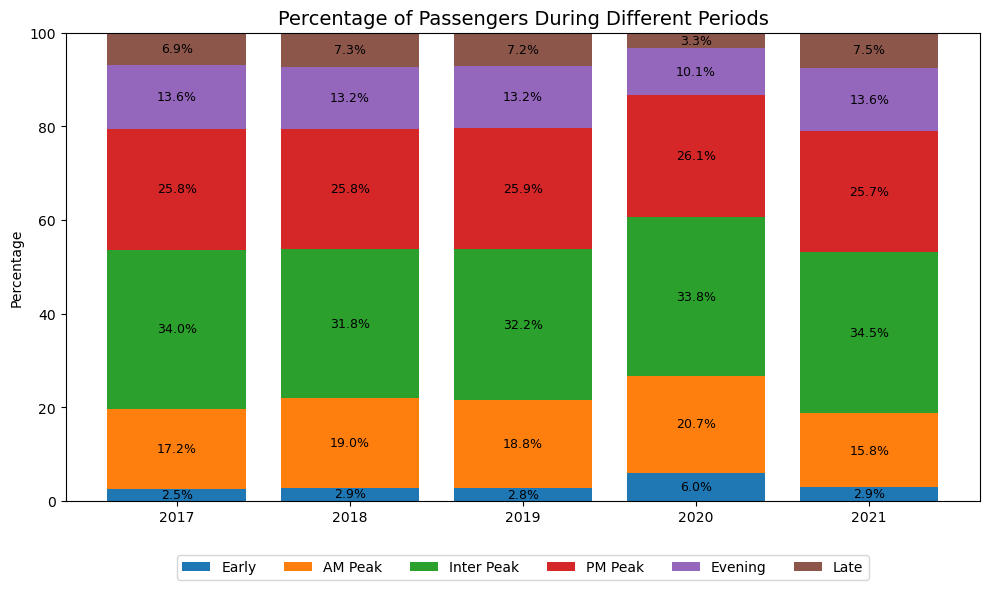

In [1290]:
# Time periods of interest
years = [2017, 2018, 2019, 2020, 2021]

# Collect data dynamically and calculate percentages
values = np.array([globals()[f'ByQhr_{year}'][time_periods].sum().values for year in years])
percentages = values / values.sum(axis=1)[:, None] * 100  # Normalize to get percentages

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(years))

for i, period in enumerate(time_periods):
    p = ax.bar(years, percentages[:, i], label=period, bottom=bottom)
    bottom += percentages[:, i]

    # Add percentage labels inside bars
    for j, bar in enumerate(p):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                f'{percentages[j, i]:.1f}%', ha='center', va='center', fontsize=9)

# Title, labels, and legend
ax.set_title("Percentage of Passengers During Different Periods", fontsize=14)
ax.set_ylabel("Percentage")
ax.set_ylim(0, 100)
ax.set_xticks(years)
ax.set_xticklabels(years)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)

plt.tight_layout()

We can see a considerable decrease in the percentage of passenger count in the AM Peak period from an average of 17.2% in 2017 to 15.8% in 2021. This can be explained by the rise in hybrid/remote work schecules. Stable percentages are maintained throughout years during other other periods.

## Webscarping Data

In this section, I webscrape data from th following website: https://www.london.gov.uk/who-we-are/what-london-assembly-does/questions-mayor/find-an-answer/tube-overcrowding-0#question. The datapoints represent the number of incidents by station attributed to crowding/congestion, which have caused delays of two minutes or more between 2015/16 and 2018/19. 

In [1291]:
overcrowding_link = "https://www.london.gov.uk/who-we-are/what-london-assembly-does/questions-mayor/find-an-answer/tube-overcrowding-0"
web = requests.get(overcrowding_link)

soup = BeautifulSoup(web.content, "lxml")

data_response = soup.find('tr').find_all_next('td')

list = []
for datapoint in data_response:
    list.append(datapoint.text.replace('\xa0', '0'))
data = list[15: -30]
print(data)

['Station', '2015-16', '2016-17', '2017-18', '2018-19', 'ACTON TOWN', '2', '4', '4', '0', 'ALDGATE EAST', '0', '0', '0', '1', 'ANGEL', '2', '1', '0', '0', 'ARCHWAY', '0', '0', '1', '0', 'ARNOS GROVE', '0', '3', '0', '0', 'ARSENAL', '0', '1', '0', '0', 'BAKER STREET', '3', '5', '2', '16', 'BANK and MONUMENT', '9', '6', '14', '16', 'BARBICAN', '1', '0', '0', '1', 'BARKING', '0', '1', '0', '1', 'BARONS COURT', '0', '0', '1', '0', 'BELSIZE PARK', '0', '0', '1', '0', 'BERMONDSEY', '4', '6', '4', '3', 'BETHNAL GREEN', '1', '0', '1', '1', 'BLACKFRIARS', '1', '0', '0', '0', 'BOND STREET', '5', '11', '0', '1', 'BOROUGH', '1', '1', '1', '1', 'BOUNDS GREEN', '0', '0', '0', '1', 'BOW ROAD', '2', '0', '0', '0', 'BURNT OAK', '1', '0', '1', '0', 'CALEDONIAN ROAD', '1', '1', '1', '1', 'CAMDEN TOWN', '4', '2', '3', '3', 'CANADA WATER', '4', '4', '4', '8', 'CANARY WHARF (JUBILEE)', '19', '13', '17', '21', 'CANNING TOWN', '2', '4', '4', '6', 'CANNON STREET', '1', '0', '0', '0', 'CHALK FARM', '0', '0', '1

## Reshaping Scraped Data

In [1292]:
headers = data[:5]
rows = data[5:]

# Group the data into chunks corresponding to the number of columns
chunk = len(headers)
structured_data = [rows[i:i + chunk] for i in range(0, len(rows), chunk)]


congestion_df = pd.DataFrame(structured_data, columns=headers)

# Convert all columns except 'Station' to numeric
for col in congestion_df.columns[1:]:  # Exclude 'Station' column
    congestion_df[col] = pd.to_numeric(congestion_df[col], errors='coerce')

# Rename the 'Station' column to '_Station' to match the column name in the merged DataFrame
congestion_df.rename(columns={'Station': '_Station'}, inplace=True)

display(congestion_df)

,_Station,2015-16,2016-17,2017-18,2018-19
0,ACTON TOWN,2,4,4,0
1,ALDGATE EAST,0,0,0,1
2,ANGEL,2,1,0,0
3,ARCHWAY,0,0,1,0
4,ARNOS GROVE,0,3,0,0
...,...,...,...,...,...
141,WHITECHAPEL,0,0,0,1
142,WILLESDEN JUNCTION,0,1,0,0
143,WIMBLEDON PARK,1,0,0,0
144,WOOD GREEN,0,1,0,1


## Studying the Correlation Between Congestion Incidents and Passenger Demand

In [1293]:
# Unify the station names in both DataFrames
congestion_df['_Station'] = congestion_df['_Station'].str.upper().str.strip()
merged_df['_Station'] = merged_df['_Station'].str.upper().str.strip()

# Merge the DataFrames on the '_Station' column
cong_df_used = congestion_df[['_Station', '2017-18', '2018-19']].drop(congestion_df.index[-1])
merged_df_used = merged_df[['_Station', 'Annualised_en/ex_2017', 'Annualised_en/ex_2018']]
cong_merged_data = pd.merge(cong_df_used, merged_df_used, on='_Station', how='inner')   
display(cong_merged_data)

# Drop the '_Station' column and calculate the correlation matrix
cong_merged_data.drop(columns=['_Station'], inplace=True)
corrs = cong_merged_data.corr()


,_Station,2017-18,2018-19,Annualised_en/ex_2017,Annualised_en/ex_2018
0,ACTON TOWN,4,0,5731527.111999,5794684.874932
1,ALDGATE EAST,0,1,13262408.265095,13707738.230351
2,ANGEL,0,0,18236122.523655,17661269.040227
3,ARCHWAY,1,0,8806365.211198,8608964.46071
4,ARNOS GROVE,0,0,4372042.286103,4263554.810123
...,...,...,...,...,...
114,WHITE CITY,1,0,8433511.134976,8389589.622631
115,WHITECHAPEL,0,1,13137261.275773,13130308.865802
116,WILLESDEN JUNCTION,0,0,4453456.162152,4984205.98526
117,WIMBLEDON PARK,0,0,2074784.798018,2155333.623908


<Axes: >

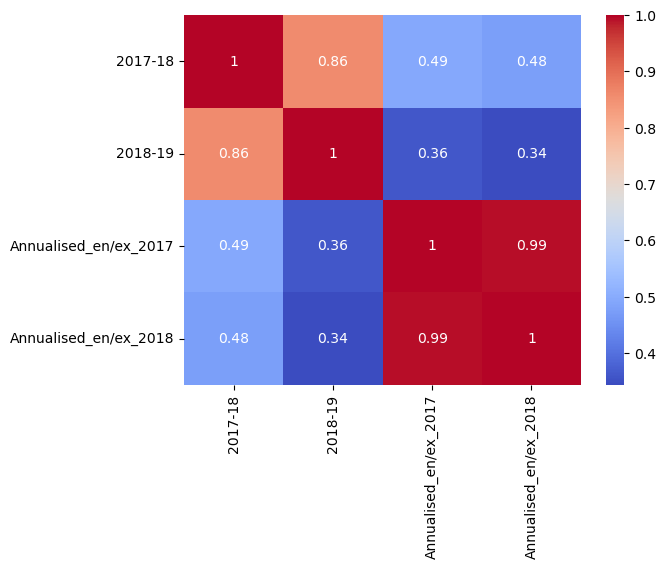

In [1294]:
# Plot the correlation matrix
sns.heatmap(corrs,cmap='coolwarm',annot=True)

The heatmap reveals a moderate positive correlation between congestion incidents and annualized passenger entry/exit numbers for the same year (e.g., 0.49 between 2017-18 congestion and 2017 passenger numbers). This suggests that stations with higher congestion incidents also experience greater passenger volumes, indicating a direct relationship between passenger demand and station crowding. 

To assess whether congestion negatively affects future passenger numbers, a lagged analysis is considered. The correlation between 2017-18 congestion incidents and 2018 passenger numbers (0.48) is slightly lower than the correlation between 2017-18 congestion and 2017 passenger numbers (0.49). While the difference is negligible, this decline implies that sustained congestion might reduce passenger growth over time, though the effect appears insignificant in the short term. 

Additionally, the near-perfect correlation between annualized entry/exit figures for consecutive years (0.99 between 2017 and 2018) suggests that passenger travel patterns are highly consistent over time, regardless of congestion incidents, likely due to habitual commuting and limited alternative routes. 

A strong correlation (0.86) between congestion incidents in 2017-18 and 2018-19 highlights the persistence of congestion at specific stations. This consistency suggests that stations experiencing congestion in one year will continue to experience congestion across future years.

##### Concluding Insights
1. The positive correlation between congestion and passenger numbers, even with a lag, suggests that congestion does not significantly deter passengers. Instead, high passenger volumes are the primary drivers of congestion. Major stations likely maintain their attractiveness due to their critical role in the transport network, regardless of crowding or delays. 

2. While the correlation decrease over time is minimal, the slight decline (0.01 for lagged years) may indicate that persistent congestion could lead to a decline in passenger numbers over an extended period. Alternatively, it may reflect that congestion levels are within a tolerable range for commuters, or that alternative routes and stations are limited.

3. Stations consistently experiencing high congestion should be prioritized for capacity expansion, infrastructure improvements, or enhanced crowd management strategies. Addressing persistent congestion could prevent future deterrence and support sustained passenger growth. 

## Network Analysis

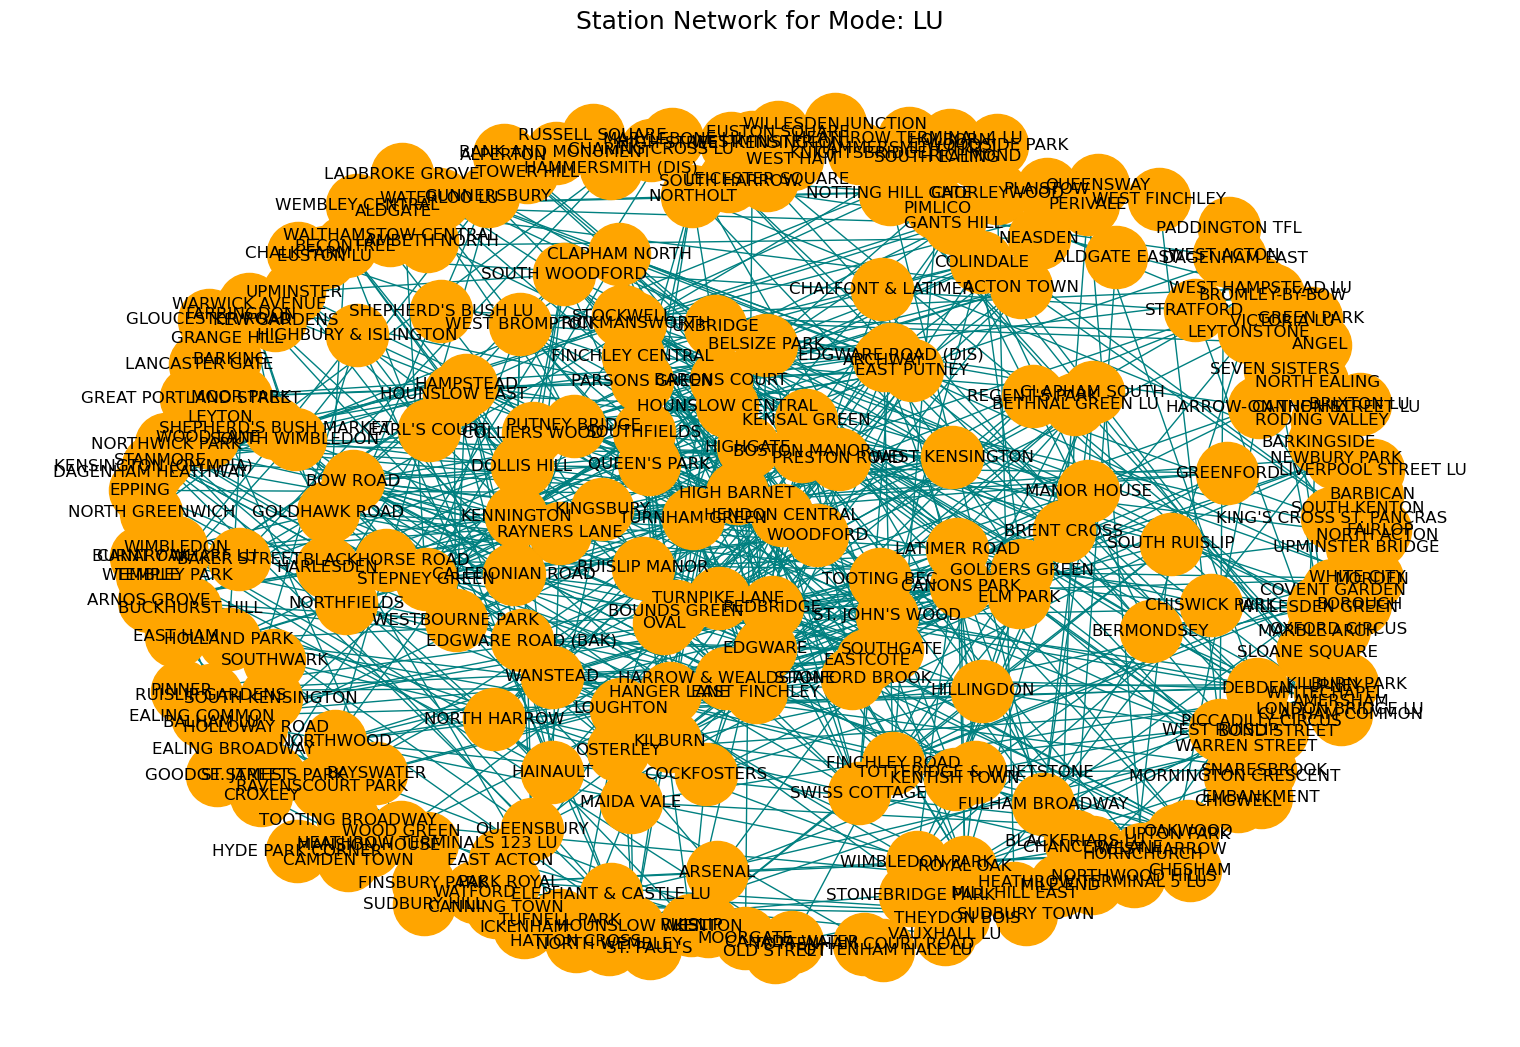

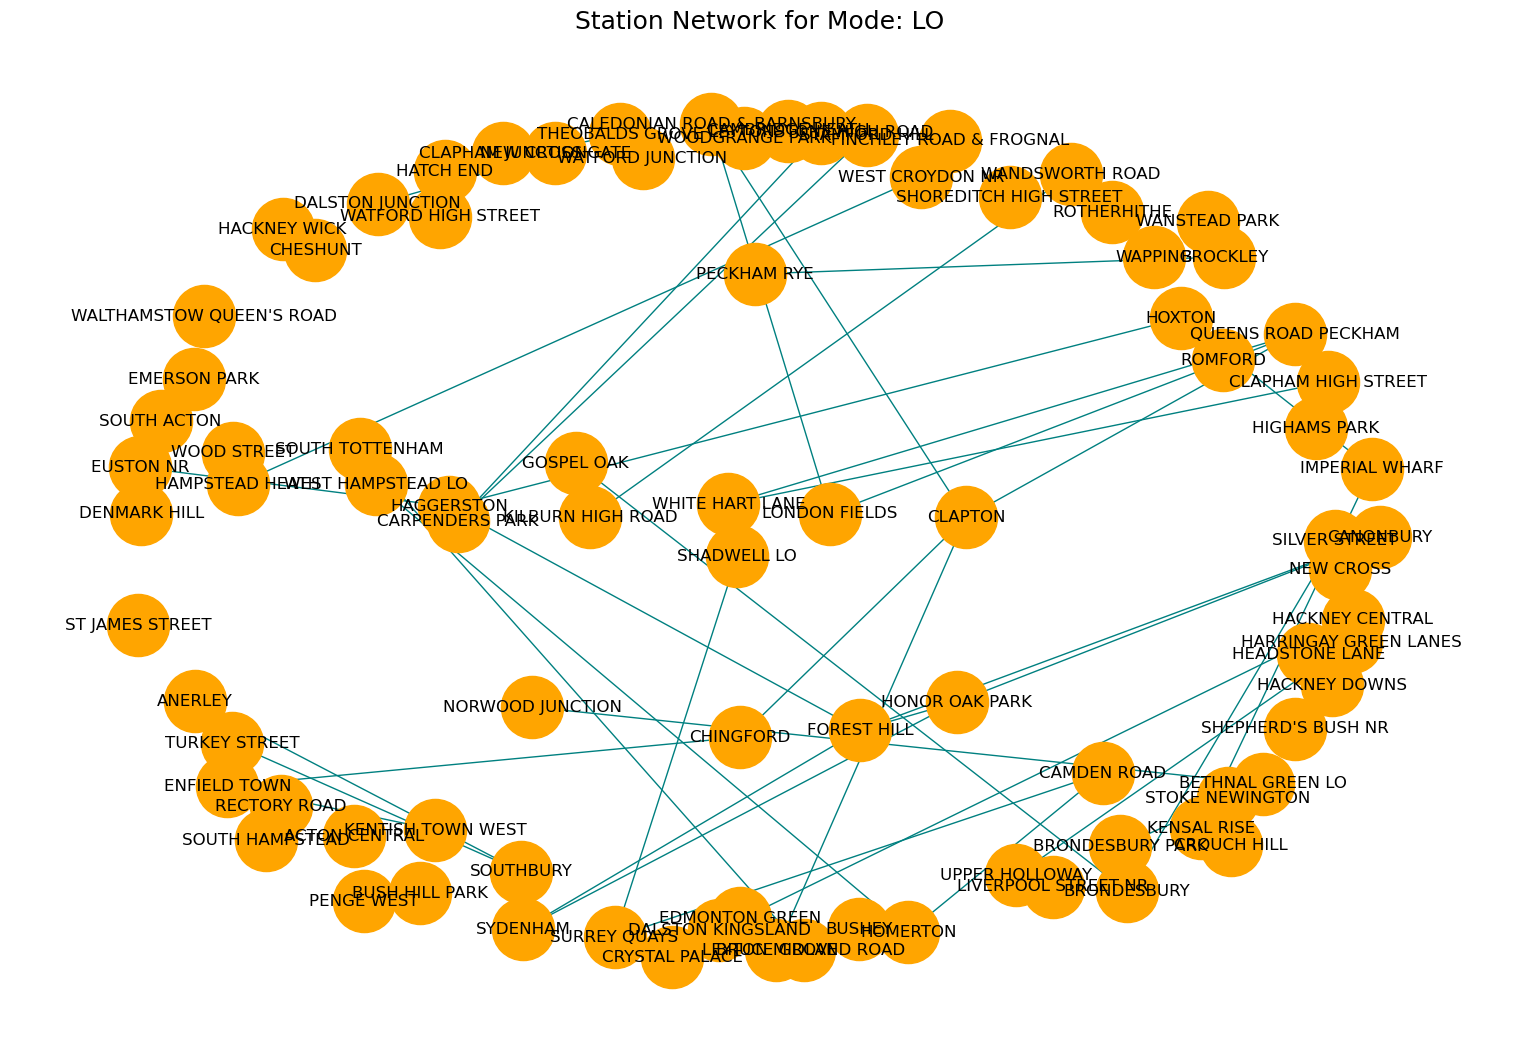

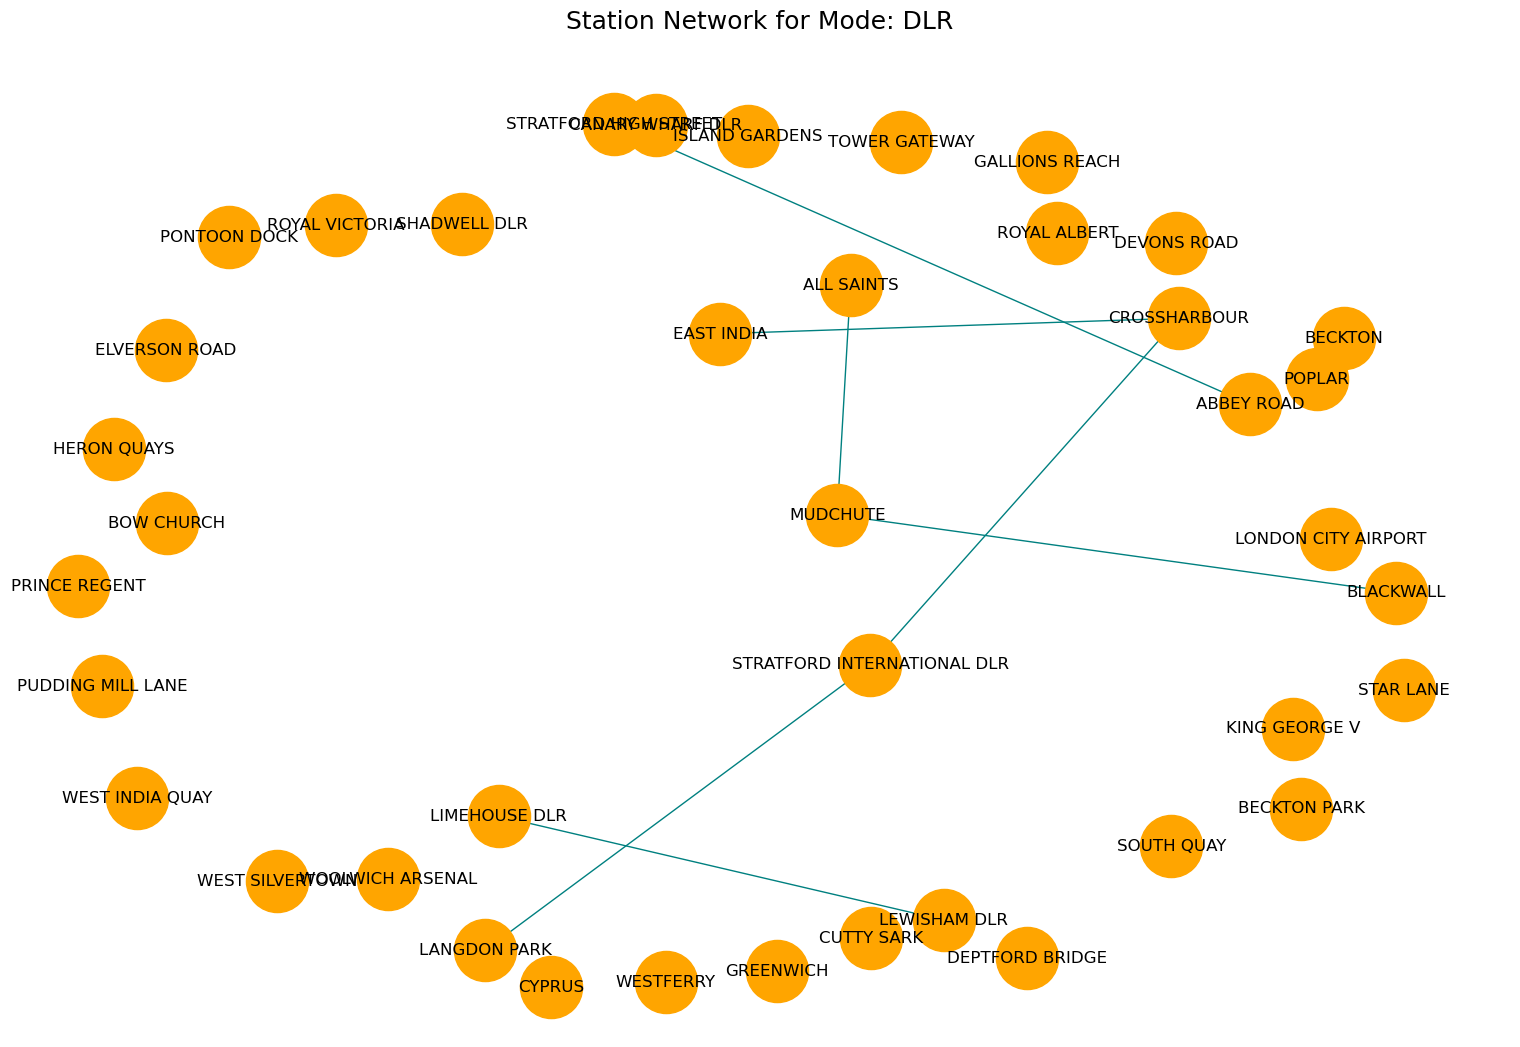

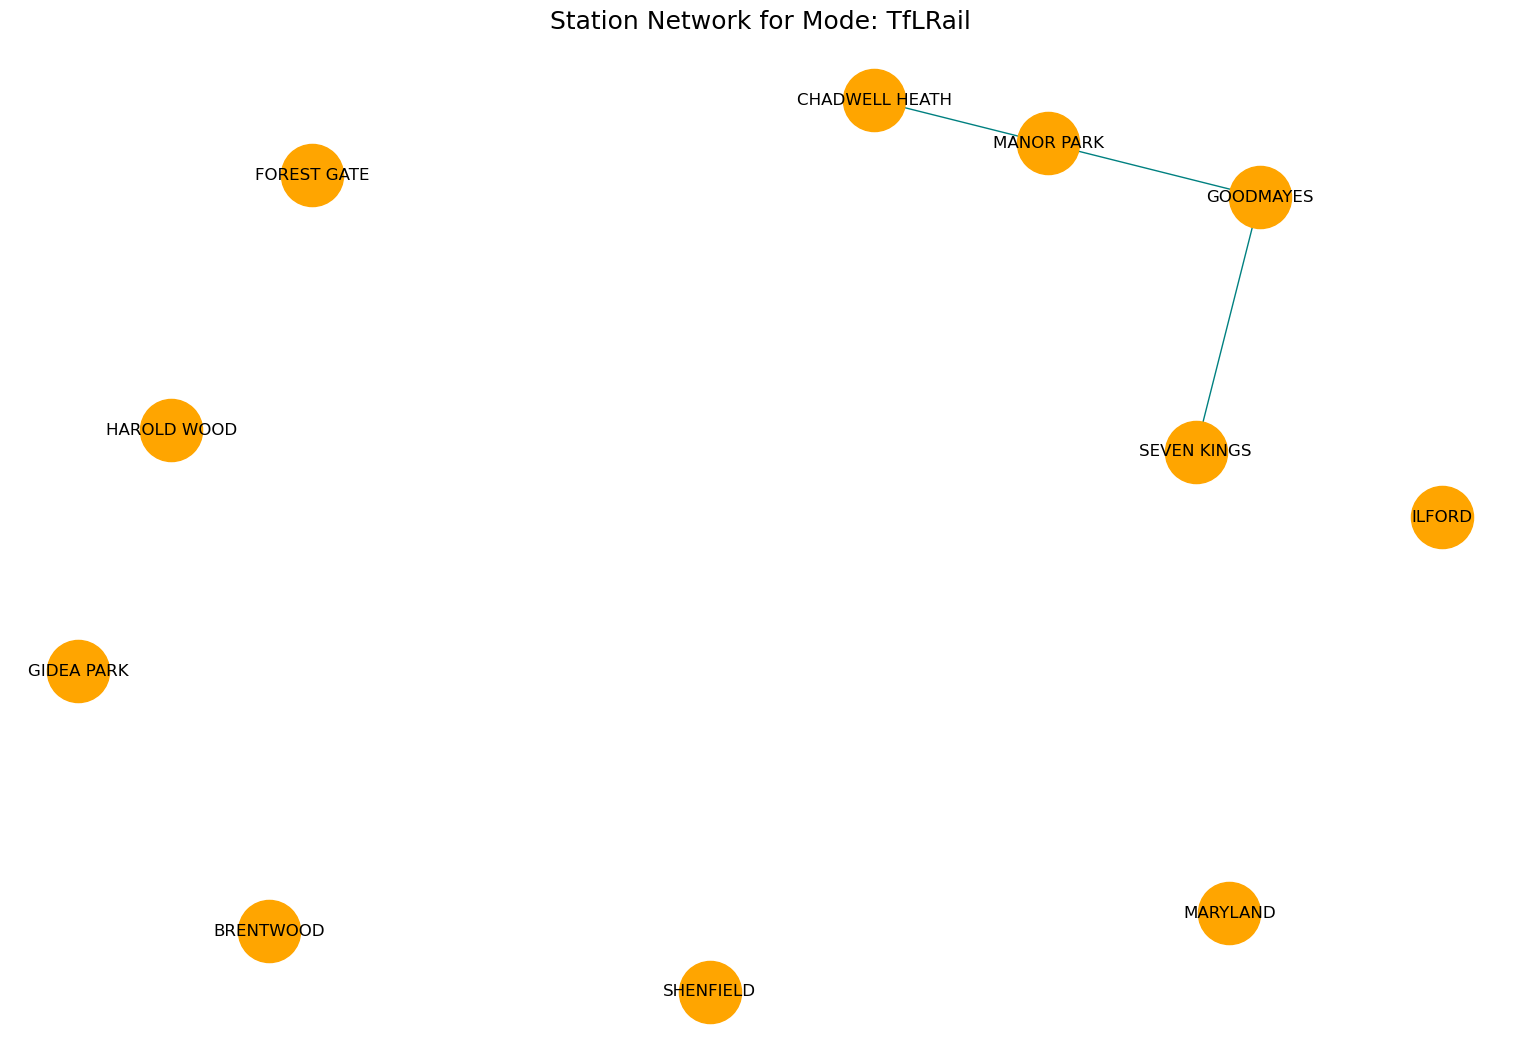

In [1299]:
# Extract all columns with entry/exit counts
entry_exit_columns = [col for col in merged_df.columns if 'Annualised_en/ex' in col]

merged_df[entry_exit_columns] = merged_df[entry_exit_columns].replace('---', np.nan)
pd.set_option('future.no_silent_downcasting', True)

merged_df[entry_exit_columns] = merged_df[entry_exit_columns].apply(lambda x: x.fillna(x.mean()))


# Scale the data for clustering to normalize yearly counts
scaler = MinMaxScaler()
merged_df[entry_exit_columns] = scaler.fit_transform(merged_df[entry_exit_columns])


# Function to calculate similarity between two stations
# Uses percentage difference to determine if two stations are "close enough" in values
def is_similar(row1, row2, threshold=20):
    def percentage_diff(a, b):
        if a == 0 and b == 0:
            return 0  # If both are zero, treat them as 0% difference
        return abs(a - b) / ((a + b) / 2) * 100

    # Calculate similarity for each year and check if all years pass the threshold
    for col in entry_exit_columns:
        if percentage_diff(row1[col], row2[col]) > threshold:
            return False
    return True

# Visualize stations by mode
for mode in merged_df['_Mode'].unique():

    # Filter dataframe by mode (LU, LO, etc.)
    mode_df = merged_df[merged_df['_Mode'] == mode]
    
    # Create a graph for the mode
    G = nx.Graph()
    
    # Add stations as nodes
    for _, row in mode_df.iterrows():
        G.add_node(row['_Station'])
    
    # Add edges between stations with similar entry/exit values across all years
    for i, row1 in mode_df.iterrows():
        for j, row2 in mode_df.iterrows():
            if i != j and is_similar(row1, row2):
                G.add_edge(row1['_Station'], row2['_Station'])

    # Visualize the graph
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=1)  # Position nodes using spring layout

    # Scale node sizes by degree
    node_sizes = [G.degree(node) * 300 for node in G.nodes()]

    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_color='orange',node_size=2000, edge_color='teal')
    

    plt.title(f'Station Network for Mode: {mode}', fontsize=18)

These network visualizations reveal the relationships between stations based on the similarity of their entry/exit values over the years that we looked at. 

The LU (London Undergroud) network graph shows dense interconnectededness  between stations, suggesting similar demand patterns for many stations. Not only does the graph show similar demand patterns between stations but also infers consistency in demand throughout the years. It is clear that two clusters are formed, one positioned in the center and the other positioned around the edges.  The dense web of connections aligns with the Underground's role as the backbone of London's transport, with consistent demand across many stations.

The LO (London Overground) graph network is similar to the LU one but is not as densely interconnected. There are apparent clusters of interconnected stations. The Overground’s role in connecting suburban areas to central hubs is evident, with a less intricate but still cohesive structure compared to the Underground.

The DLR network is linear and sparse, with distinct edges. This highlights the DLR’s design, which serves specific corridors like Canary Wharf and East London with limited overlap between edges. The less interconnected nature reflects the DLR's focused purpose of linking Docklands and East London to other parts of the city, emphasizing direct point-to-point travel rather than widespread interconnectivity, and hence lower passenger demand.

These insights can be useful for optimizing service planning, resource allocation, and infrastructure development to meet passenger demand effectively and efficiently. 